<a href="https://colab.research.google.com/github/jalkestrup/fastai_course/blob/main/02_deployment/dogs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cat & Dog model
*Based on Gradio Pets, https://colab.research.google.com/drive/1M-mzhZdFQ2XWBSbLCuKzrmLsm0aLEYxQ?usp=sharing*

In [2]:
!pip install -Uqq fastai

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dtu_fastai_path = '/content/drive/My Drive/dtu/fastAI/02_deployment'
import os
# List all files in the dtu_fastai_path
print(os.listdir(dtu_fastai_path))

['dog_cat_model.pkl']


# Creating different dataloaders
**Varying image resizing/cropping and trying ImageDataLoaders vs DataBlocks**

In [5]:
from fastai.vision.all import *

def is_cat(x): return x[0].isupper() 

In [6]:
path = untar_data(URLs.PETS)/'images'

dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat,
    item_tfms=Resize(192))

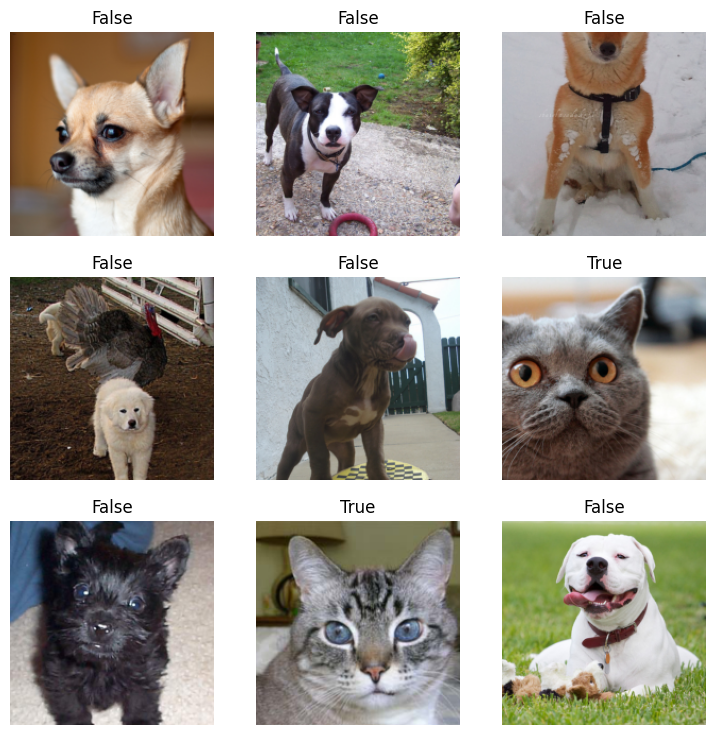

In [7]:
dls.show_batch()

In [8]:
dls2 = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat,
    #Resize random part of image
    item_tfms=RandomResizedCrop(192))

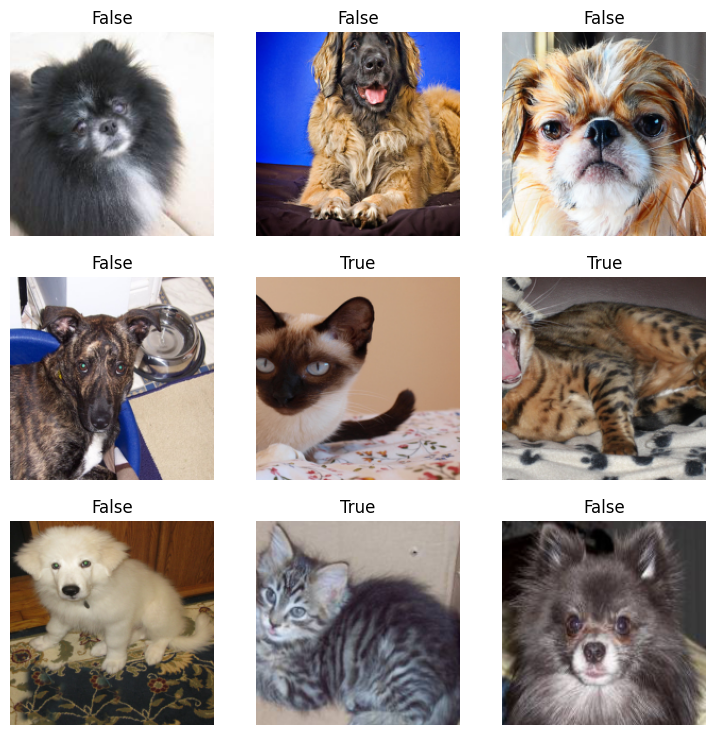

In [9]:
dls2.show_batch()

In [15]:
#Alternatively write the datablock from scratch, more closely as in the tutorial from part 1
#Requires slightly modifyin the is_cat labeling function

def is_cat2(x): 
    return x.name[0].isupper()

dls3 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y = is_cat2,
    item_tfms = RandomResizedCrop(192),
    batch_tfms = aug_transforms
).dataloaders(path)

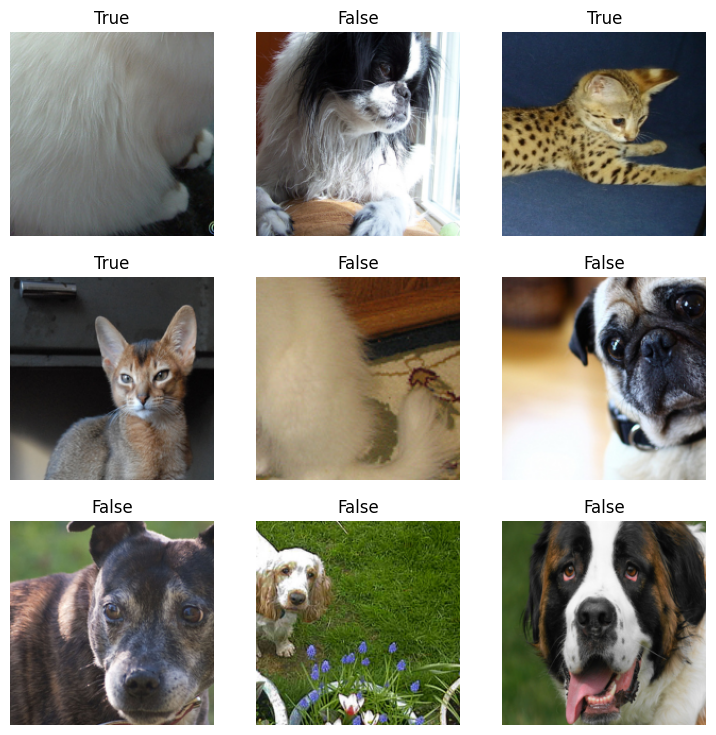

In [16]:
dls3.show_batch()

# Training a model

In [6]:
#Vision learner with resize 192
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 321MB/s]


In [9]:
#Vision learner with random resize crop
learn_2 = vision_learner(dls2, resnet18, metrics=error_rate)
learn_2.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 116MB/s]


In [17]:
#Vision learner with random resize crop and data augmentation
learn_3 = vision_learner(dls3, resnet18, metrics=error_rate)
learn_3.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


# Intepreting model and cleaning data

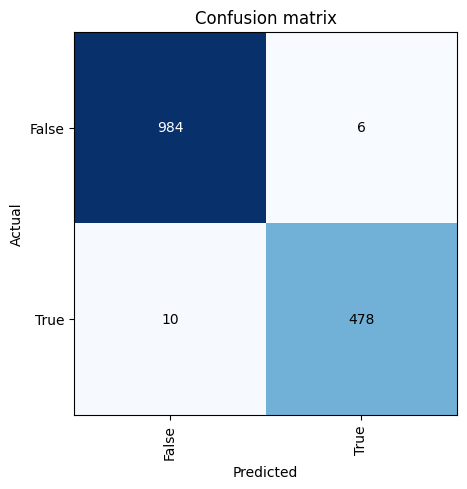

In [18]:
interp = ClassificationInterpretation.from_learner(learn_3)
interp.plot_confusion_matrix()

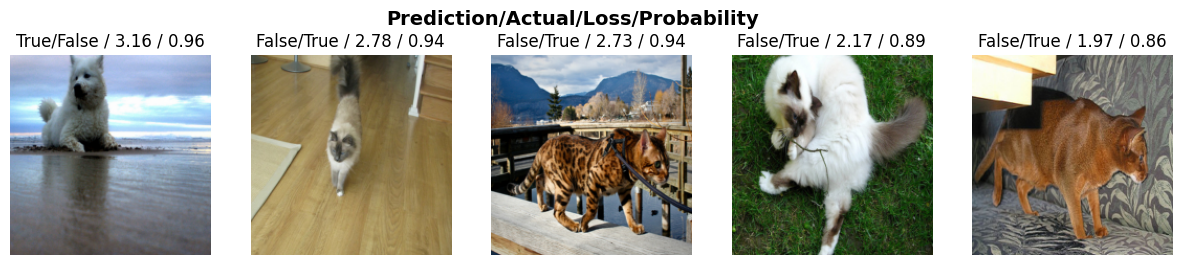

In [19]:
interp.plot_top_losses(5, nrows=1)

plot_top_losses shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction.

The above is usefull to check whether the labels of the data seem correct, or the data itself corrupt. In this case the labels does look true and the images seem correct (if there is a leopad colored cat?)

**Relabeling images**

In case some images needed to be relabeled,fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:


In [22]:
from fastai.vision.widgets import ImageClassifierCleaner

#hide_output
cleaner = ImageClassifierCleaner(learn_3)
cleaner

If data is augmented using the cleaner, the cleaner only returns the indexes of those images to be deleted/changed. Hence to apply the changes to the dataset the following is needed>

In [24]:
#For deleting data
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

#For moving images between folders after re-labeling (if labels are infered from folder names, NOT this case)
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

#From ChatGPT:: Renaming mislabeled images when labels are infered from upper or lowercase (Not tested)
"""
for idx,cat in cleaner.change():
    fn = cleaner.fns[idx]
    if cat:
        # If the image is now labeled as a cat, make sure the name starts with uppercase
        new_fn = fn.parent/(fn.stem[0].upper() + fn.stem[1:] + fn.suffix)
    else:
        # If the image is now labeled as a dog, make sure the name starts with lowercase
        new_fn = fn.parent/(fn.stem[0].lower() + fn.stem[1:] + fn.suffix)
    fn.rename(new_fn)
"""

## Saving the model

In [15]:
#Save the model to the mounted google drive
learn.export(dtu_fastai_path + '/dog_cat_model.pkl')

In [23]:
#Save the model to the mounted google drive
learn_3.export(dtu_fastai_path + '/dog_cat_model_3.pkl')